In [1]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Torch-TensorRT Getting Started - ResNet 50

## Overview

In the practice of developing machine learning models, there are few tools as approachable as PyTorch for developing and experimenting in designing machine learning models. The power of PyTorch comes from its deep integration into Python, its flexibility and its approach to automatic differentiation and execution (eager execution). However, when moving from research into production, the requirements change and we may no longer want that deep Python integration and we want optimization to get the best performance we can on our deployment platform. In PyTorch 1.0, TorchScript was introduced as a method to separate your PyTorch model from Python, make it portable and optimizable. TorchScript uses PyTorch's JIT compiler to transform your normal PyTorch code which gets interpreted by the Python interpreter to an intermediate representation (IR) which can have optimizations run on it and at runtime can get interpreted by the PyTorch JIT interpreter. For PyTorch this has opened up a whole new world of possibilities, including deployment in other languages like C++. It also introduces a structured graph based format that we can use to do down to the kernel level optimization of models for inference.

When deploying on NVIDIA GPUs TensorRT, NVIDIA's Deep Learning Optimization SDK and Runtime is able to take models from any major framework and specifically tune them to perform better on specific target hardware in the NVIDIA family be it an A100, TITAN V, Jetson Xavier or NVIDIA's Deep Learning Accelerator. TensorRT performs a couple sets of optimizations to achieve this. TensorRT fuses layers and tensors in the model graph, it then uses a large kernel library to select implementations that perform best on the target GPU. TensorRT also has strong support for reduced operating precision execution which allows users to leverage the Tensor Cores on Volta and newer GPUs as well as reducing memory and computation footprints on device.

Torch-TensorRT is a compiler that uses TensorRT to optimize TorchScript code, compiling standard TorchScript modules into ones that internally run with TensorRT optimizations. This enables you to continue to remain in the PyTorch ecosystem, using all the great features PyTorch has such as module composability, its flexible tensor implementation, data loaders and more. Torch-TensorRT is available to use with both PyTorch and LibTorch.

### Learning objectives

This notebook demonstrates the steps for compiling a TorchScript module with Torch-TensorRT on a pretrained ResNet-50 network, and running it to test the speedup obtained.

## Content
1. [Requirements](#1)
1. [ResNet-50 Overview](#2)
1. [Creating TorchScript modules](#3)
1. [Compiling with Torch-TensorRT](#4)
1. [Conclusion](#5)

In [2]:
!pip install numpy==1.21.2 scipy==1.5.2 Pillow==6.2.0 scikit-image==0.17.2 matplotlib==3.3.0
!nvidia-smi

Tue Oct 26 00:13:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0    24W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   

<a id="1"></a>
## 1. Requirements

Follow the steps in `notebooks/README` to prepare a Docker container, within which you can run this notebook.

<a id="2"></a>
## 2. ResNet-50 Overview


PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our ResNet-50 model from there pretrained on ImageNet.

### Model Description

This ResNet-50 model is based on the [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) paper, which describes ResNet as “a method for detecting objects in images using a single deep neural network". The input size is fixed to 32x32.

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>




In [3]:
import torch
import torchvision

torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

resnet50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [4]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

!wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

mkdir: cannot create directory ‘./data’: File exists
--2021-10-26 00:13:33--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.226.251.36, 13.226.251.27, 13.226.251.107, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.226.251.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.002s  

2021-10-26 00:13:34 (13.1 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2021-10-26 00:13:34--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8001::4, 2620:12a:8000::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, a

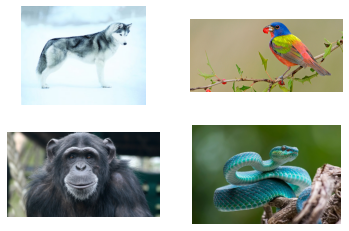

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    input_tensor = preprocess(img)      
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')

In [6]:
import json 
  
with open("./data/imagenet_class_index.json") as json_file: 
    d = json.load(json_file)
    
print("Number of classes in ImageNet: {}".format(len(d)))

Number of classes in ImageNet: 1000


In [7]:
import numpy as np

def rn50_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

# decode the results into ([predicted class, description], probability)
def predict(img_path, model):
    img = Image.open(img_path)
    preprocess = rn50_preprocess()
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
        # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
        sm_output = torch.nn.functional.softmax(output[0], dim=0)
        
    ind = torch.argmax(sm_output)
    return d[str(ind.item())], sm_output[ind] #([predicted class, description], probability)

./data/img0.JPG - Predicted: ['n02110185', 'Siberian_husky'], Probablility: 0.49787256121635437
./data/img1.JPG - Predicted: ['n01820546', 'lorikeet'], Probablility: 0.6447006464004517
./data/img2.JPG - Predicted: ['n02481823', 'chimpanzee'], Probablility: 0.9899842739105225
./data/img3.JPG - Predicted: ['n01749939', 'green_mamba'], Probablility: 0.4564124643802643


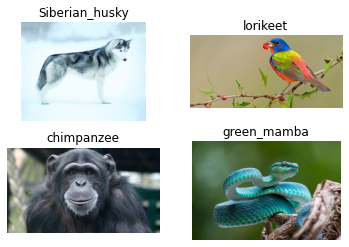

In [8]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    
    pred, prob = predict(img_path, resnet50_model)
    print('{} - Predicted: {}, Probablility: {}'.format(img_path, pred, prob))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(pred[1])

### Benchmark utility

Let us define a helper function to benchmark a model.

In [9]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [10]:
# Model benchmark without Torch-TensorRT
model = resnet50_model.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 109.12 ms
Iteration 20/100, ave batch time 109.08 ms
Iteration 30/100, ave batch time 109.10 ms
Iteration 40/100, ave batch time 109.12 ms
Iteration 50/100, ave batch time 109.11 ms
Iteration 60/100, ave batch time 109.10 ms
Iteration 70/100, ave batch time 109.10 ms
Iteration 80/100, ave batch time 109.11 ms
Iteration 90/100, ave batch time 109.13 ms
Iteration 100/100, ave batch time 109.13 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 109.13 ms


<a id="3"></a>
## 3. Creating TorchScript modules

To compile with Torch-TensorRT, the model must first be in **TorchScript**. TorchScript is a programming language included in PyTorch which removes the Python dependency normal PyTorch models have. This conversion is done via a JIT compiler which given a PyTorch Module will generate an equivalent TorchScript Module. There are two paths that can be used to generate TorchScript: **Tracing** and **Scripting**. 

- Tracing follows execution of PyTorch generating ops in TorchScript corresponding to what it sees. 
- Scripting does an analysis of the Python code and generates TorchScript, this allows the resulting graph to include control flow which tracing cannot do. 

Tracing is more likely to compile successfully with Torch-TensorRT due to simplicity (though both systems are supported). We start with an example of the traced model in TorchScript.

## Tracing

Tracing follows the path of execution when the module is called and records what happens. This recording is what the TorchScript IR will describe. 

To trace an instance of the model, we can call torch.jit.trace with an example input. 

In [11]:
model = resnet50_model.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((128, 3, 224, 224)).to("cuda")])

We can save this model and use it independently of Python.

In [12]:
# This is just an example, and not required for the purposes of this demo
torch.jit.save(traced_model, "resnet_50_traced.jit.pt")

In [13]:
# Obtain the average time taken by a batch of input
benchmark(traced_model, input_shape=(128, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 109.04 ms
Iteration 20/100, ave batch time 109.04 ms
Iteration 30/100, ave batch time 109.03 ms
Iteration 40/100, ave batch time 109.05 ms
Iteration 50/100, ave batch time 109.04 ms
Iteration 60/100, ave batch time 109.04 ms
Iteration 70/100, ave batch time 109.04 ms
Iteration 80/100, ave batch time 109.04 ms
Iteration 90/100, ave batch time 109.05 ms
Iteration 100/100, ave batch time 109.06 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 109.06 ms


<a id="4"></a>
## 4. Compiling with Torch-TensorRT

TorchScript modules behave just like normal PyTorch modules and are intercompatible. From TorchScript we can now compile a TensorRT based module. This module will still be implemented in TorchScript but all the computation will be done in TensorRT.

As mentioned earlier, we start with an example of Torch-TensorRT compilation with the traced model.

Note that we show benchmarking results of two precisions: FP32 (single precision) and FP16 (half precision).

### FP32 (single precision)

In [18]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model_fp32 = torch_tensorrt.compile(traced_model, **{
    "inputs": [torch_tensorrt.Input((128, 3, 224, 224), dtype=torch.float32)],
    "enabled_precisions": {torch.float32}, # Run with FP32
    "workspace_size": 1 << 22
})



In [19]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp32, input_shape=(128, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 93.58 ms
Iteration 20/100, ave batch time 85.57 ms
Iteration 30/100, ave batch time 92.02 ms
Iteration 40/100, ave batch time 89.07 ms
Iteration 50/100, ave batch time 86.80 ms
Iteration 60/100, ave batch time 89.88 ms
Iteration 70/100, ave batch time 88.58 ms
Iteration 80/100, ave batch time 87.30 ms
Iteration 90/100, ave batch time 86.28 ms
Iteration 100/100, ave batch time 88.27 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 88.27 ms


### FP16 (half precision)

In [21]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model = torch_tensorrt.compile(traced_model, **{
    "inputs": [torch_tensorrt.Input((128, 3, 224, 224), dtype=torch.half)],
    "enabled_precisions": {torch.float, torch.half}, # Run with FP16
    "workspace_size": 1 << 22
})


The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True



In [23]:
# Obtain the average time taken by a batch of input
benchmark(trt_model, input_shape=(128, 3, 224, 224), dtype='fp16', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 18.76 ms
Iteration 20/100, ave batch time 18.85 ms
Iteration 30/100, ave batch time 18.93 ms
Iteration 40/100, ave batch time 18.96 ms
Iteration 50/100, ave batch time 18.92 ms
Iteration 60/100, ave batch time 18.94 ms
Iteration 70/100, ave batch time 18.98 ms
Iteration 80/100, ave batch time 18.97 ms
Iteration 90/100, ave batch time 19.08 ms
Iteration 100/100, ave batch time 22.90 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 22.90 ms


<a id="5"></a>
## 5. Conclusion

In this notebook, we have walked through the complete process of compiling TorchScript models with Torch-TensorRT for ResNet-50 model and test the performance impact of the optimization. With Torch-TensorRT, we observe a speedup of **1.4X** with FP32, and **3.0X** with FP16.

### What's next
Now it's time to try Torch-TensorRT on your own model. Fill out issues at https://github.com/NVIDIA/Torch-TensorRT. Your involvement will help future development of Torch-TensorRT.
